# Exercise 7 - Code

*Perform random failure simulations with a Barabási-Albert networks with 100 and 1000 nodes and two different numbers of preferentially attached edges and with the `protein.edgelist.txt` data set. Interprete briefly what you find for the breakdown threshold in both experiments.*

*Repeat this experiment for Erdős-Renyi networks but run the simulations 100 times and average over the resulting threshold values. What is your expectation for this value? Compare it to the numerical result.*

In [1]:
import networkx as nx
import numpy as np
import random
from matplotlib import pyplot as plt

plt.rcdefaults()
plt.style.use("seaborn")
plt.rc("figure", figsize=(11.2, 6.3))
plt.rc("font", size=12)

path = "../data/"

In [2]:
def random_failure(G: nx.Graph, m: int = 1) -> tuple:
    N = len(G)
    if N % m == 0:
        n_steps = N // m - 1
    else:
        n_steps = N // m
    steps = np.arange(n_steps + 2)

    C = G.copy()
    core_proportions = np.zeros(n_steps + 2)
    core_proportions[0] = 1
    breakdown = []

    for step in steps[1:-1]:
        C.remove_nodes_from(random.sample(list(C.nodes), m))
        core = C.subgraph(max(nx.connected_components(C), key=len))
        core_proportions[step] = len(core) / N
        core_degrees = np.array(list(dict(nx.degree(core)).values()))
        if np.mean(core_degrees) < 2:
            breakdown.append(m*step/N)

    return m*steps/N, core_proportions, breakdown[0]

def analytical_breakdown(G: nx.Graph) -> float:
    degrees = np.array(list(dict(nx.degree(G)).values()))
    return 1 - 1 / (np.sum(degrees**2) / np.sum(degrees) - 1)

In [3]:
Ns = [100, 1000]
Ms = [2, 10]

networks = {f"Barabási-Albert({N}, {m})" : nx.barabasi_albert_graph(N, m) for N in Ns for m in Ms}
networks.update({"Protein network" : nx.read_edgelist(path + "protein.edgelist.txt")})

In [4]:
results = {name : random_failure(network, max(1,len(network)//200)) for name, network in networks.items()}

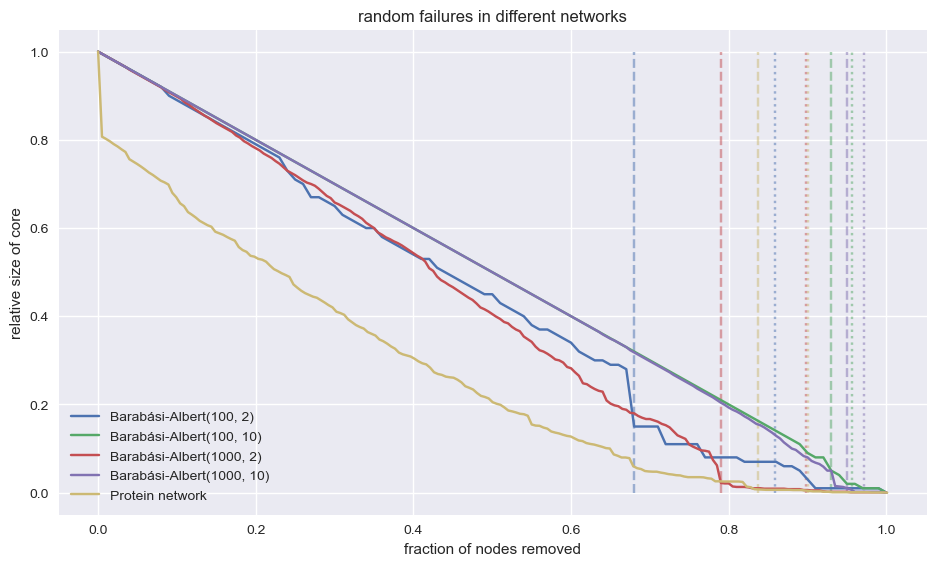

In [5]:
for i, (name, result) in enumerate(results.items()):
    fractions, core_proportions, threshold = result
    plt.plot(fractions, core_proportions, color=f"C{i}", label=name)
    plt.vlines(threshold, 0, 1, linestyle="dashed", color=f"C{i}", alpha=0.5)
    plt.vlines(analytical_breakdown(networks[name]), 0, 1, linestyle="dotted", color=f"C{i}", alpha=0.5)

plt.title("random failures in different networks")
plt.ylabel("relative size of core")
plt.xlabel("fraction of nodes removed")
plt.legend(loc="lower left")
plt.show()

The dashed lines represent the computational breakdown threshold, when the average degree in the core is below 2, whereas dotted lines represent the analytical breakdown threshold, $f_c = 1 - \left( \frac{\langle k^2 \rangle}{\langle k \rangle} - 1 \right)^{-1}$, of the respective network with the same color.

Some observations:
- The Barabási-Albert networks are more robust to random failures if the preferential attachment $m$ is high, since if more links are introduced. If the number of nodes is higher then it is also more robust but not as much, which can be seen by the similar rate of decline of the networks with the same parameter $m.$
- The two networks with the higher preferential attachment decline more smoothly than the other networks which appear to have bigger jumps at different points.
- The computational thresholds are lower than the analytical ones except for the $(1000, 10)$-network where they are almost identical. On the other hand in the protein network the computational threshold is higher.
- The protein network core seems to shrink a lot in the beginning but then its reduction in size declines.

In [6]:
n_runs = 100
Ns = np.arange(100, 1001, 100)
p = 0.02

theoretical = 1 - (Ns-1) / ((Ns-1)*Ns*p+1)

mean_computational = np.zeros(len(Ns))
mean_analytical = np.zeros(len(Ns))

for i, N in enumerate(Ns):
    analytical = np.zeros(n_runs)
    computational = np.zeros(n_runs)
    for j in range(n_runs):
        G = nx.erdos_renyi_graph(N, p)
        analytical[j] = analytical_breakdown(G)
        *_, computational[j] = random_failure(G, max(1,N//100))
    mean_analytical[i] = np.mean(analytical)
    mean_computational[i] = np.mean(computational)

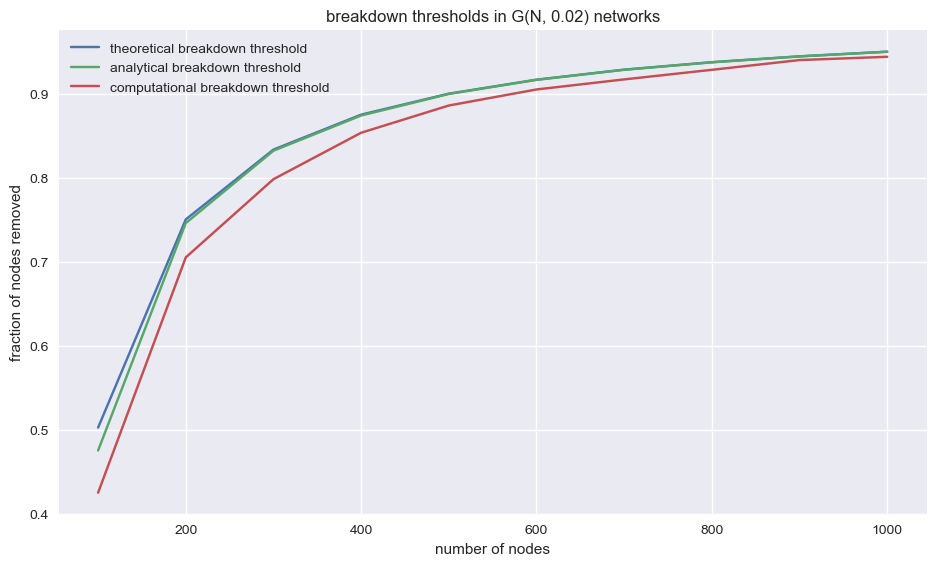

In [7]:
plt.title(f"breakdown thresholds in G(N, {p}) networks")
plt.plot(Ns, theoretical, label="theoretical breakdown threshold")
plt.plot(Ns, mean_analytical, label="analytical breakdown threshold")
plt.plot(Ns, mean_computational, label="computational breakdown threshold")
plt.legend()
plt.xlabel("number of nodes")
plt.ylabel("fraction of nodes removed")
plt.show()

In [8]:
def simulate(N: int = 100, p: float = 0.1, n_runs: int = 100) -> None:
    theoretical_breakdown = 1 - (N-1) / ((N-1)*N*p+1)

    computational_breakdowns = np.zeros(n_runs)
    analytical_breakdowns = np.zeros(n_runs)

    for i in range(n_runs):
        G = nx.erdos_renyi_graph(N, p)
        analytical_breakdowns[i] = analytical_breakdown(G)
        fractions, core_proportions, computational_breakdowns[i] = random_failure(G, max(1,N//100))
        plt.plot(fractions, core_proportions, color="C0", alpha=1/n_runs)
    
    plt.vlines(np.mean(computational_breakdowns), 0, 1, color="C1", label="mean computational breakdown threshold")
    plt.vlines(np.mean(analytical_breakdowns), 0, 1, color="C2", label="mean analytical breakdown threshold")
    plt.vlines(theoretical_breakdown, 0, 1, color="C3", label="theoretical breakdown threshold")

    plt.title(f"random failures of {n_runs} G({N}, {p}) networks")
    plt.ylabel("relative size of core")
    plt.xlabel("fraction of nodes removed")
    plt.legend(loc="lower left")
    plt.show()

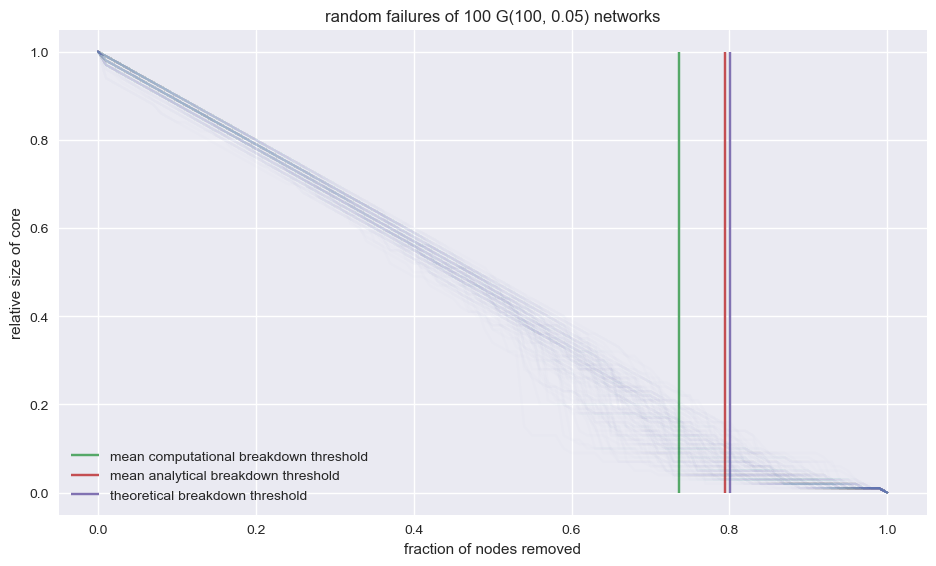

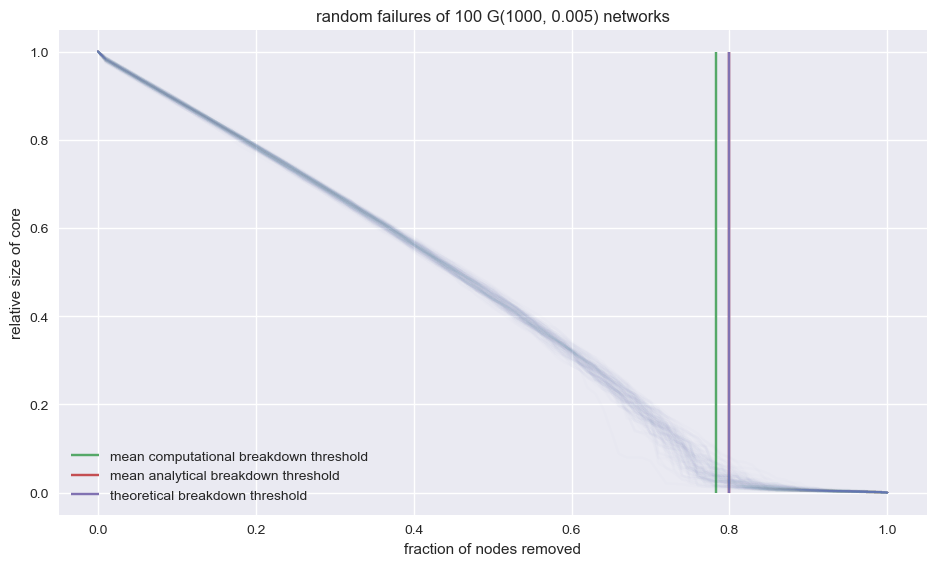

In [9]:
Ns = np.array([100, 1000])
ps = 5 / Ns
n_runs = 100

for N, p in zip(Ns, ps):
    simulate(N, p, n_runs)

Some observations:
- The mean computational breakdown threshold is lower than the other two in both cases but it seems to converge to the theoretical result for $N \to \infty.$
- The mean analytical threshold is very close to the theoretical one and will probably converge to it for increasing number of runs.